## Chapter 13: Multi-layer Perceptrons 

# 13.6 Stochastic and mini-batch gradient descent

In [1]:
# some standard imports
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad as compute_grad   
from autograd.misc.flatten import flatten_func
from mlrefined_libraries import multilayer_perceptron_library as mlplib

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

In this Section we introduce two extensions of gradient descent known as *stochastic* and *mini-batch* gradient descent which, computationally speaking, are significantly more effective than the standard (or batch) gradient descent method, when applied to large datasets. With today's availability of very large image/audio/text-based datasets, stochastic and mini-batch gradient descent have become an integral part of modern optimization.

## 13.6.1 Decomposing the gradient 

As the size of a dataset grows, storing it in active memory in order to compute the gradient becomes challenging if not impossible. Luckily with the particular type of cost functions used in machine learning and deep learning, there is a way out. Notice, how every cost function $g$ we have seen so far in the book can be written as a sum of individual costs over each data point

\begin{equation}
g\left(\mathbf{\mathbf{w}}\right) = \underset{p=1}{\overset{P}{\sum}}{h\left(\mathbf{w},\mathbf{x}_p,y_p\right)} 
\end{equation}

For example, with Least Squares regression we have 

\begin{equation}
h\left(\mathbf{w},\mathbf{x}_p,y_p\right) = \left(\mathbf{x}_{p}^{T}\mathbf{w}-y_p\right)^2 
\end{equation}

or with two-class classification, we can write the softmax cost in terms of individual data points by setting 

\begin{equation}
h\left(\mathbf{w},\mathbf{x}_p,y_p\right) = \text{log}\left(1+ e^{-y_p\mathbf{x}_{p}^{T}\mathbf{w}}\right)
\end{equation}

The same is true with multi-class classification and nonlinear versions of these costs. This simple observation, that machine learning cost functions can be decomposed over individual data points, is important because it allows us to write the gradient itself as a summation of the gradients of each of the $P$ summands

\begin{equation}
\nabla g\left(\mathbf{\mathbf{w}}\right) = \nabla \left(\underset{p=1}{\overset{P}{\sum}}{h\left(\mathbf{w},\mathbf{x}_p,y_p\right)}\right)=\underset{p=1}{\overset{P}{\sum}}{\nabla h\left(\mathbf{w},\mathbf{x}_p,y_p\right)}
\end{equation}

Thus when minimizing any cost function via gradient descent we can think about the $k^{th}$ gradient descent step in terms of these individual gradients, as

\begin{equation}
\mathbf{w}^k = 
\mathbf{w}^{k-1}-\alpha_{k} \nabla g\left(\mathbf{\mathbf{w}}^{k-1}\right) = \mathbf{w}^{k-1}-\alpha_{k} \underset{p=1}{\overset{P}{\sum}}{\nabla h\left(\mathbf{w}^{k-1},\mathbf{x}_p,y_p\right)}
\end{equation}

where $\alpha_{k}$ is - as always - an appropriately chosen steplength.

The elegance of the gradient decomposition in (5) is that it allows us to load a single data point at a time in memory, compute the gradient of the cost with respect to that data point, add the result to a container, discard the data point to free up the memory, and move to the next data point. After all data points are visited once, we can then take a gradient step using what is stored in the gradient container.

Note that this scheme works for any large dataset regardless of how large $P$ is and how small our active memory is (as long as we can load in a single data point). One just needs to wait for $P$ evaluations of the gradient before taking a step. This brings forth an interesting question: what if, instead of waiting for all individual gradient terms to be computed, we take a step as soon as a gradient term becomes available? Will this produce a properly convergent method? How will it compare to standard gradient descent in (5)? 

## 13.6.2 The stochastic gradient descent

The idea of taking a sequence of gradient steps in each data point (as opposed to a full/batch gradient step over the entire dataset) leads to a procedure called stochastic gradient descent. The $k^{th}$ iteration of stochastic gradient descent, sometimes called an *epoch*, consists of $P$ sequential point-wise gradient steps written as

\begin{equation}
\mathbf{w}^{k,p} = 
\mathbf{w}^{k,p-1}-\alpha_{k} \nabla h\left(\mathbf{w}^{k, p-1}, \mathbf{x}_p, y_p\right), \qquad p=1,\ldots,P
\end{equation}


In analogy with the $k^{th}$ batch gradient step in (5), here we have used the double superscript
$\mathbf{w}^{k,p}$ which reads "the $p^{th}$ individual gradient step of the $k^{th}$ stochastic gradient descent
iteration." In this notation the initial point of the $k^{th}$ iteration is written as $\mathbf{w}^{k,0}$, the   
corresponding sequence of $P$ individual gradient steps as $\left(\mathbf{w}^{k,1},\mathbf{w}^{k,2},\ldots,\mathbf{w}^{k,P}\right)$, and the final output of the $k^{th}$ iteration (i.e., the $P^{th}$ stochastic step) as $\mathbf{w}^{k,P}=\mathbf{w}^{k+1,0}$. After completing the $k^{th}$ iteration we perform the $\left(k+1\right)^{th}$  iteration by cycling through the data again, taking individual gradient steps for $p=1,\ldots,P$.

To reaffirm the vocabulary being used here, with the standard or batch gradient descent we often use "step" and "iteration" interchangeably, i.e., each iteration consists of one full gradient step in all $P$ data points simultaneously as shown in equation (5). Conversely, with the stochastic method we refer to a single "iteration" or "epoch" as consisting of all $P$ individual gradient steps, one in each data point, executed sequentially for $p=1,\ldots,P$ as shown in equation (6). Figure 1 illustrates the first iteration of both methods schematically. 

<figure>
<img src= '../../mlrefined_images/tricks/stochastic_first_iteration.png' width="100%" height="auto"/>
<figcaption> <strong>Figure 1:</strong> <em> Schematic comparison of first iteration of (top) batch and (bottom) stochastic gradient descent, using a dataset with three data points. </em>
</figcaption>
</figure>

## 13.6.3 The mini-bacth gradient descent

That we can decompose machine learning cost functions over individual data points, as shown in equation (1), led to derivation of the stochastic gradient descent step in equation (6). Note that the cost function in (1) can be written more generally, as
 
\begin{equation}
g\left(\mathbf{\mathbf{w}}\right) = \underset{j=1}{\overset{J}{\sum}}\underset{p\in \Omega_j}{\sum}{h\left(\mathbf{w},\mathbf{x}_p,y_p\right)} 
\end{equation} 

where $\Omega_1, \Omega_2, \ldots, \Omega_J$ denote a certain partitioning of the set $\left\{1,2,\ldots,P\right\}$ into $J$ index sets. These index sets divide the dataset into $J$ subsets, each called a *mini-batch*, where every data point belongs to **one and only one** mini-batch. 

Analogous to equation (4) we have

\begin{equation}
\nabla g\left(\mathbf{\mathbf{w}}\right) = \nabla \left(\underset{j=1}{\overset{J}{\sum}}\underset{p\in \Omega_j}{\sum}{h\left(\mathbf{w},\mathbf{x}_p,y_p\right)} \right)= \underset{j=1}{\overset{J}{\sum}}\nabla \left(\underset{p\in \Omega_j}{\sum}{h\left(\mathbf{w},\mathbf{x}_p,y_p\right)}\right) 
\end{equation}

where the gradient is now decomposed over each mini-batch (as opposed to each data point), and mini-batch gradient descent is then the algorithm wherein we take gradient steps sequentially using each mini-batch. Ideally we want all mini-batches to have the same size - a parameter we call the *batch size* - or be as equally-sized as possible when $J$ does not divide $P$. Notice, a batch size of $1$ turns mini-batch gradient descent into stochastic gradient descent, whereas a batch size of $P$ turns it into the standard or batch gradient descent.

The code cell below contains Python implementation of the mini-batch gradient descent algorithm based on the standard gradient descent algorithm we saw previously in Chapter 6, where it is now slightly adjusted to take in the total number of data points as well as the size of each mini-batch via the input variables <code>num_pts</code> and <code>batch_size</code>, respectively.  

In [2]:
def minibatch_gradient_descent(g, w, alpha, num_pts, batch_size, max_its, version):    
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
    w_hist.append(unflatten(w))
    
    # how many mini-batches equal the entire dataset?
    num_batches = int(np.ceil(np.divide(num_pts, batch_size)))
    # over the line
    for k in range(max_its):   
        # loop over each minibatch
        for b in range(num_batches):
            # collect indices of current mini-batch
            batch_inds = np.arange(b*batch_size, min((b+1)*batch_size, num_pts))

            # plug in value into func and derivative
            grad_eval = grad(w, batch_inds)
            grad_eval.shape = np.shape(w)

            ### normalized or unnormalized descent step? ###
            if version == 'normalized':
                grad_norm = np.linalg.norm(grad_eval)
                if grad_norm == 0:
                    grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
                grad_eval /= grad_norm
            
            # take descent step with momentum
            w = w - alpha*grad_eval

        # record weight update
        w_hist.append(unflatten(w))

    return w_hist

#### <span style="color:#a50e3e;">Example 1. </span>  Batch vs. mini-batch gradient descent on a 10K face detection dataset

In this Example we compare $100$ iterations of batch and mini-batch (batch size =$100$) gradient descent using softmax on a real two-class classification dataset collected for the task of face detection, consisting of $P=10,000$ face and non-face images.

In [3]:
# load data
datapath = '../../mlrefined_datasets/convnet_datasets/feat_face_data.csv'
data = np.loadtxt(datapath,delimiter = ',')
x = data[:,:-1]
y = data[:,-1:]
num_pts = len(y)

When applying mini-batch gradient descent it is common practice to first randomize the order of the data prior to running the algorithm to make sure each mini-batch has data points from both classes.  

In [4]:
# randomize the order of data
perm = np.random.permutation(len(x))
x = x[perm]
x = x.T
y = y[perm]

To use mini-batch gradient descent we need a cost function that, in addition to the vector $\mathbf{w}$, also takes in the designated mini-batch. Be careful, we do not want <code>autograd</code> to differentiate with respect to this variable. Most built-in functions in Python are immune to differentiation by <code>autograd</code>, and so we can use them to represent the mini-batch input variable. Here we use <code>iter</code>, a built in Python function for iteration to form the softmax cost function. 

In [5]:
# compute linear combination of input point
def model(x,w):
    # tack a 1 onto the top of each input point all at once
    o = np.ones((1,np.shape(x)[1]))
    x = np.vstack((o,x))
    
    # compute linear combination and return
    a = np.dot(x.T,w)
    return a

In [6]:
def minibatch_softmax(w, iter):
    # get subset of points
    x_p = x[:, iter]
    y_p = y[iter]
    
    cost = (1/len(y_p))*np.sum(np.log(1 + np.exp(-y_p*model(x_p,w))))
    return cost

We now run batch and mini-batch gradient descent with the same initialization and fixed steplength for $100$ iterations and plot the cost function evaluation as well as number of misclassifications for each iteration.   

<IPython.core.display.Javascript object>


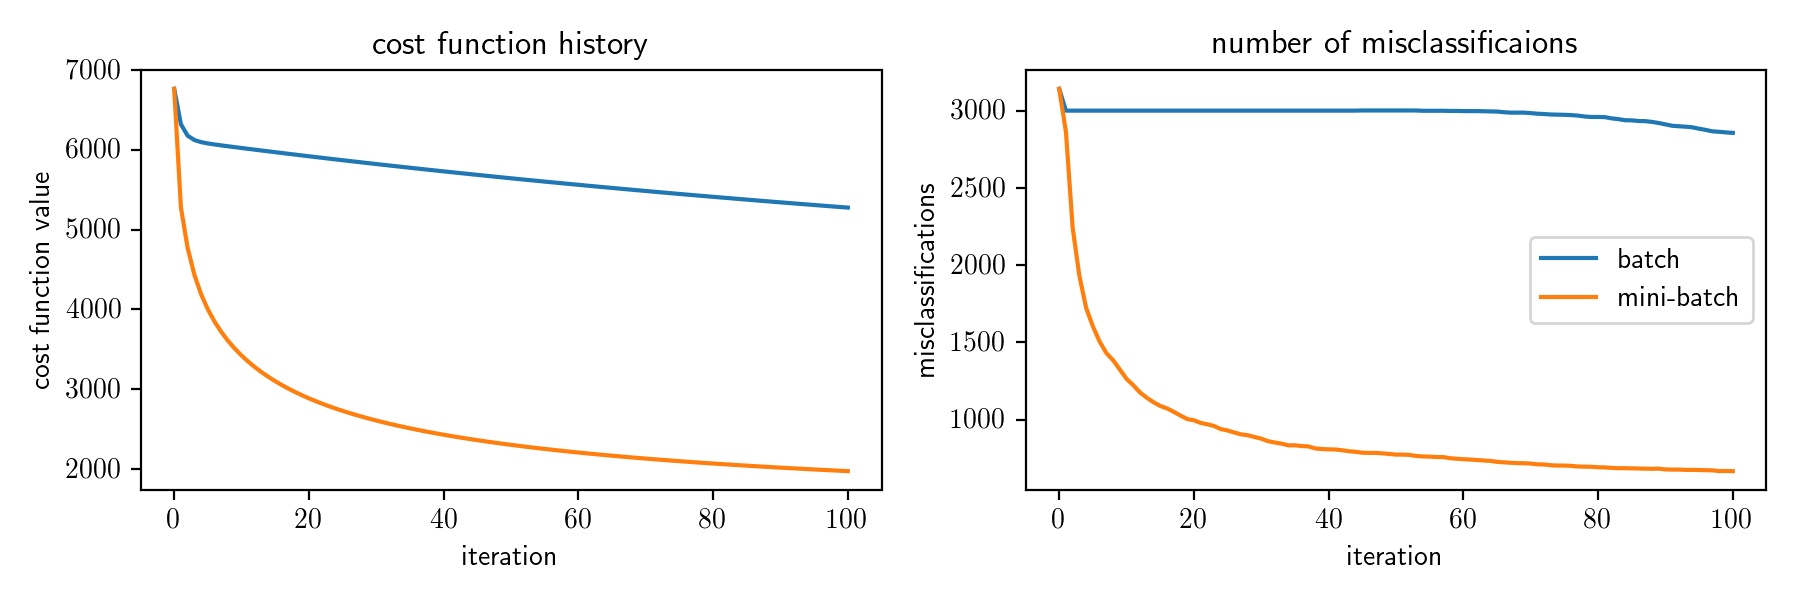

In [7]:
demo1 = mlplib.plotters.Visualizer()
demo1.compare_classification_histories(minibatch_softmax, x, y,
                                       batch_size=100, alpha=1, max_its=100, version='unnonrmlized')

#### <span style="color:#a50e3e;">Example 2. </span>  Batch vs. mini-batch gradient descent on MNIST

In this Example we compare $40$ iterations of batch and mini-batch (batch size =$500$) gradient descent using multi-class perceptron cost on the MNIST dataset consisting of $P=70,000$ images of hand-written digits 0-9.

In [8]:
# load data
from sklearn.datasets import fetch_mldata
MNIST = fetch_mldata('MNIST original')
x = MNIST.data.astype('float64')
y = np.reshape(MNIST.target, (-1, 1))
num_pts = len(y)

In [9]:
# randomize data
perm = np.random.permutation(len(x))
x = x[perm]
x = x.T
y = y[perm]

Once again all we need to do here is slightly adjust the multiclass perceptron cost function to allow for computing the cost for any given subset of data.  

In [10]:
lam = 10**-3  # our regularization paramter 
def minibatch_multiclass_perceptron(w, iter):
    
    # get subset of points
    x_p = x[:, iter]
    y_p = y[iter]
    
    # pre-compute predictions on all points
    all_evals = model(x_p,w)
    
    # compute maximum across data points
    a =  np.max(all_evals, axis = 1)        
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[np.arange(len(y_p)), y_p.astype(int).flatten()]
    cost = np.sum(a - b)
    
    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
    # return average
    return cost/float(len(y_p))

We now run batch and mini-batch gradient descent with the same initialization and fixed steplength for $40$ iterations and plot the cost function evaluation as well as number of misclassifications for each iteration. 

<IPython.core.display.Javascript object>


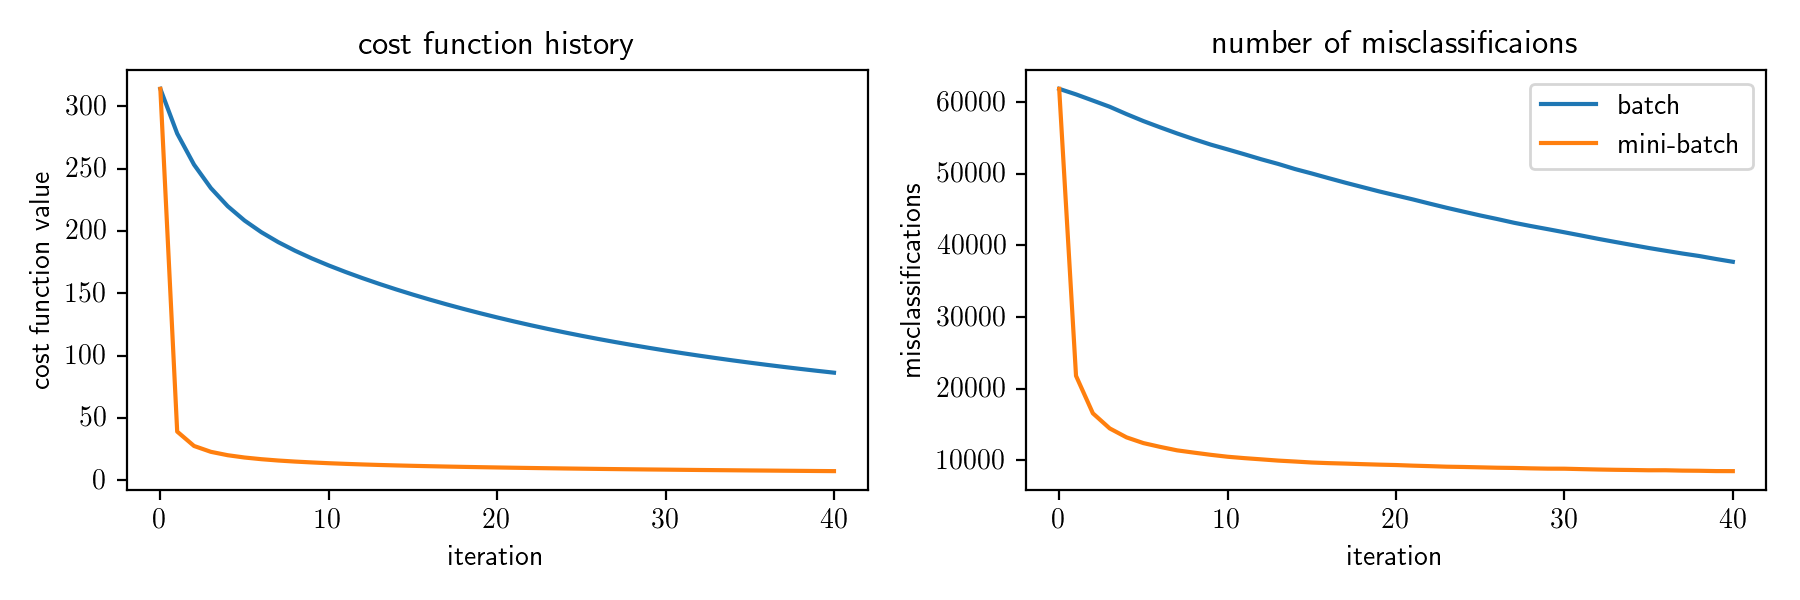

In [11]:
demo2 = mlplib.plotters.Visualizer()
demo2.compare_classification_histories(minibatch_multiclass_perceptron, x, y,
                                       batch_size=500, alpha=1e-4, max_its=40, version='unnonrmlized')

## 13.6.4 Behind the efficacy of stochastic and mini-batch gradient descent

The result of the previous Example is indicative of a major computational advantage of stochastic/mini-batch gradient descent over the standard batch version for dealing with large datasets. When initialized far from a point of convergence the stochastic/mini-batch methods tend in practice to progress much faster towards a solution. In other words, and as illustrated figuratively in Figure 2, taking a large number of 'imperfect' mini-batch steps is more effective in reducing the cost function evaluation than taking a considerably smaller number of 'perfect' gradient steps via the batch method. This is confirmed by substantial empirical evidence (see e.g., [[1,2]](#bib_cell) and references therein).

<figure>
<img src= '../../mlrefined_images/tricks/batch_vs_minibatch.png' width="100%" height="auto"/>
<figcaption> <strong>Figure 2:</strong> <em> Illustrative comparison of (top) batch and (bottom) mini-batch gradient descent (with a batch size of $3$). Even though an individual mini-batch step can potentially increase the overall evaluation of the cost function, in practice mini-batch steps tend to progress much faster towards a solution compared to batch gradient descent schemes, especially when initialized far from the point of convergence. </em>
</figcaption>
</figure>

It is noteworthy that because moderately accurate solutions (provided by a moderate amount of minimization of a cost function) tend to perform reasonably well in machine learning applications, and because with large datasets a random initialization will tend to lie far from a convergent point, in many cases even a single iteration of stochastic/mini-batch gradient descent can provide a good solution.

> Stochastic and mini-batch gradient descent tend to work extremely well with large datasets.

## 13.6.5 On Steplength selection for stochastic and mini-batch gradient descent

A diminishing steplength can guarantee the convergence of the stochastic gradient method (see Appendix for a formal proof). More precisely, a steplength rule satisfying the following two requirements is guaranteed to cause the stochastic gradient descent procedure to converge to a stationary point:

1. The step size must diminish as the number of iterations increases: $\alpha_k \rightarrow 0$ as $k \rightarrow \infty$

2. The sum of the steplengths is not finite: ${\sum^{\infty}_{k=1}}{\alpha_k}=\infty$ 

Common choices of steplength with the stochastic gradient method include $\alpha_k = \frac{1}{k}$, $\alpha_k=\frac{1}{\sqrt{k}}$, or variations of these (see [[1]](#bib_cell) for further information about how to choose particular variations of these step lengths in practice). 

In practice however, one may successfully use other step length rules such as fixed steplengths. If tuned properly on a given dataset, fixed steplengths can work very well in practice (as was used in Examples 1 and 2) even though they do may not ensure convergence theoretically. 

<a id='bib_cell'></a>

## References

[1]  Léon Bottou. Large-scale machine learning with stochastic grant descent. In Proceedings of COMPSTAT’2010, pp. 177–186. Springer, 2010.

[2]  Dimitri P Bertsekas. Incremental gradient, subgradient, and proximal methods for convex optimization: A survey. In Optimization for Machine Learning, 2010, 1–38, MIT Press, 2011.